# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [ ]:
!pip install datasets==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

### Import Packages

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed, LlamaModel, LlamaConfig
from datasets import load_dataset
from typing import Dict, Any, Optional

### Check Devices

In [ ]:
!nvidia-smi

Sat Apr  5 08:23:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [ ]:
set_seed(0)

# Prepare Data

### Define Dataset

In [ ]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [ ]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/501 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/632 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/80 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/80 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/297 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/167 [00:00<?, ? examples/s]

### Visualization

In [ ]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

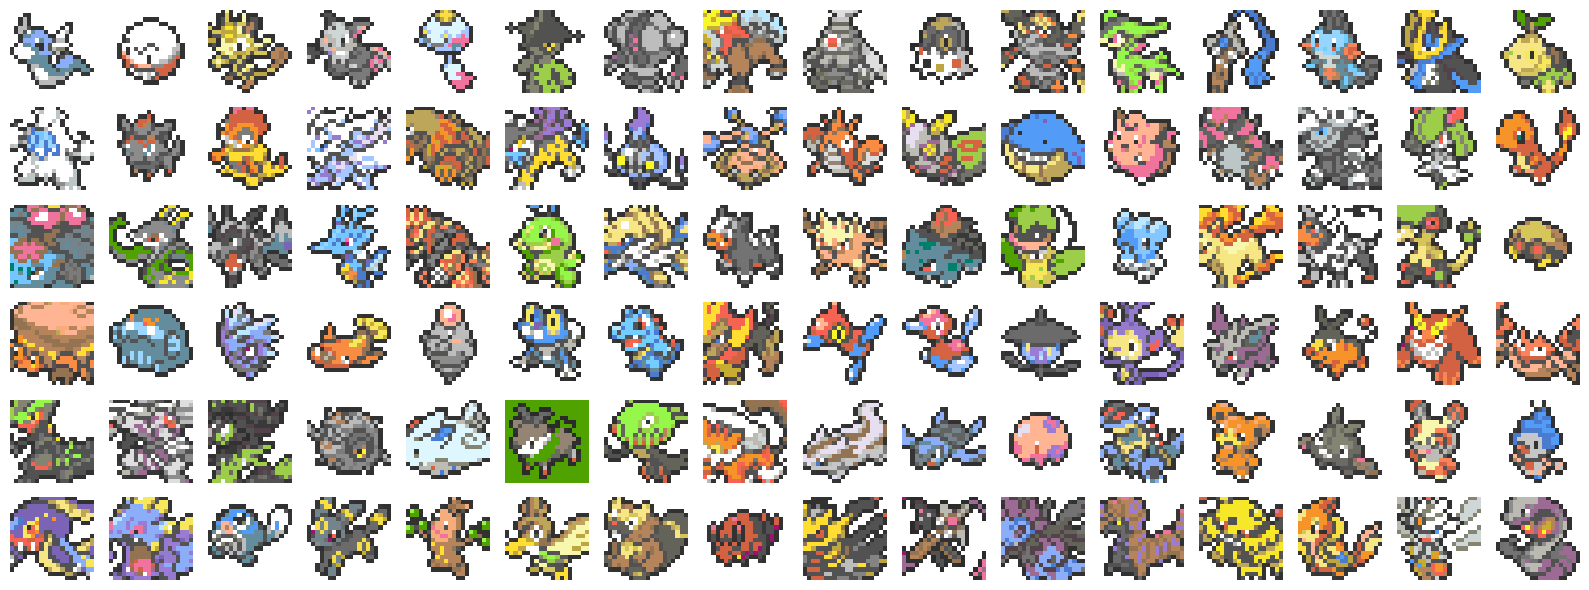

In [ ]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

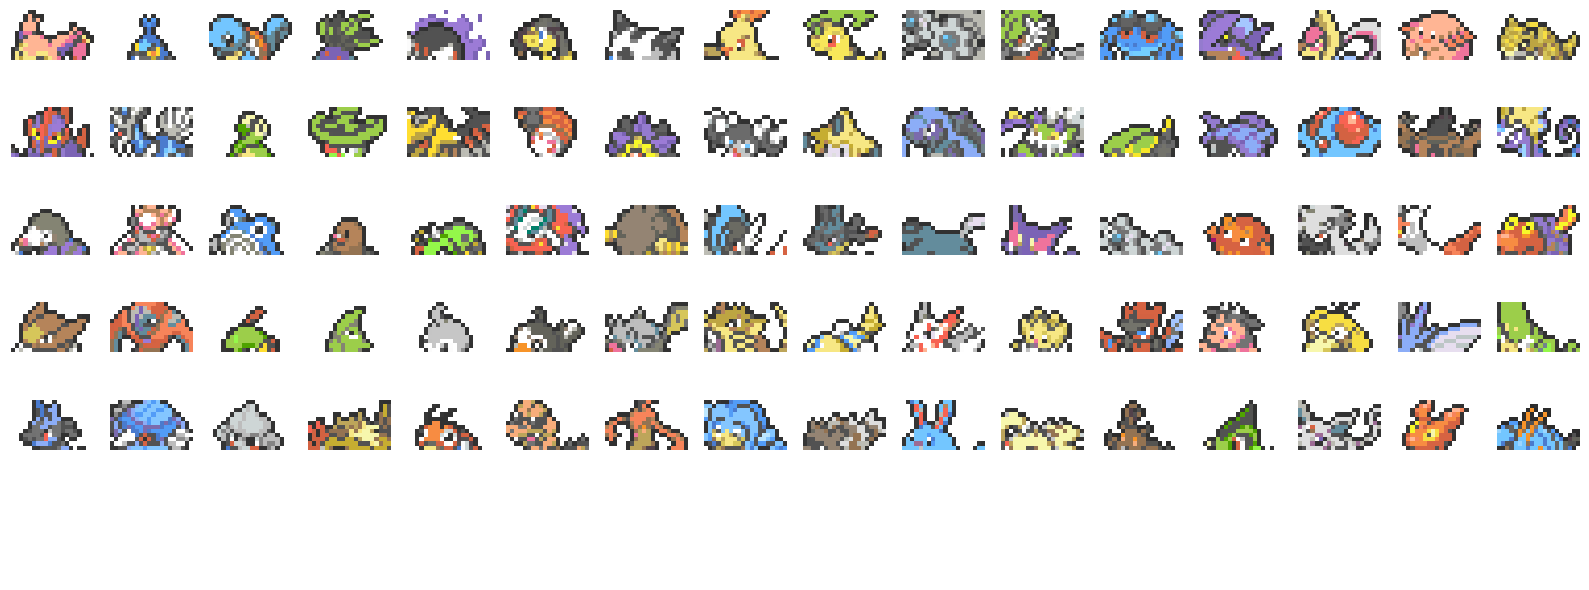

In [ ]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


In [ ]:
# Define GPT-2 model configuration as a dictionary
gpt2_config = {
    "activation_function": "gelu_new",    # Activation function used in the model
    "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
    "attn_pdrop": 0.1,            # Dropout rate for attention layers
    "embd_pdrop": 0.1,            # Dropout rate for embeddings
    "initializer_range": 0.02,        # Standard deviation for weight initialization
    "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
    "model_type": "gpt2",           # Type of model
    "n_ctx": 128,               # Context size (maximum sequence length)
    "n_embd": 64,              # Embedding size
    "n_head": 2,               # Number of attention heads
    "n_layer": 2,              # Number of transformer layers
    "n_positions": 400,           # Maximum number of token positions
    "resid_pdrop": 0.1,           # Dropout rate for residual connections
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

# Load GPT-2 model configuration from dictionary
# config = GPT2Config.from_dict(gpt2_config)

# Define Llama model configuration
llama_config = {
    "hidden_act": "silu",                     # Activation function used in the model
    "architectures": ["LlamaForCausalLM"],    # Specifies the model type
    "hidden_size": 192,                       # Hidden layer size (embedding dimension)
    "vocab_size": num_classes,                # Number of unique tokens in vocabulary
    "num_attention_heads": 4,                 # Number of attention heads
    "num_hidden_layers": 4,                   # Number of transformer layers
    "initializer_range": 0.02,                # Standard deviation for weight initialization
    "intermediate_size": 512,                 # Size of the intermediate feed-forward layer
    "max_position_embeddings": 400,           # Maximum number of token positions
    "model_type": "llama",                    # Type of model
    "rms_norm_eps": 1e-6,                     # Small constant for RMSNorm stability
    "tie_word_embeddings": False,             # Whether to tie input and output embeddings
    "bos_token_id": 0,                        # Beginning of sequence token ID
    "eos_token_id": None,                     # End of sequence token ID (None means not explicitly defined)
    "pad_token_id": None,                     # Padding token ID
}

# Load Llama model configuration from dictionary
config = LlamaConfig.from_dict(llama_config)

### Load Model

In [ ]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(167, 192)
    (layers): ModuleList(
      (0-3): 4 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=192, out_features=192, bias=False)
          (k_proj): Linear(in_features=192, out_features=192, bias=False)
          (v_proj): Linear(in_features=192, out_features=192, bias=False)
          (o_proj): Linear(in_features=192, out_features=192, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=192, out_features=512, bias=False)
          (up_proj): Linear(in_features=192, out_features=512, bias=False)
          (down_proj): Linear(in_features=512, out_features=192, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((192,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((192,), eps=1e-06)
      )
    )
    (norm): LlamaRMSNorm((192,), eps=1e-06)
    (rotary_emb): LlamaRotaryEmbedding

# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [ ]:
# Training Parameters
epochs = 200                                      # Number of training epochs
learning_rate = 1e-4                                 # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

### Save Model Function

In [ ]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [ ]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

Training Epoch 1/200: 100%|██████████| 40/40 [00:04<00:00,  8.46it/s]


Epoch 1/200, Loss: 3.9012


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 1/200, Reconstruction Accuracy: 0.4100
Model saved at checkpoints/best_model.pth (Loss: 3.9012, Epoch: 1)


Training Epoch 2/200: 100%|██████████| 40/40 [00:01<00:00, 21.11it/s]


Epoch 2/200, Loss: 3.3848


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 2/200, Reconstruction Accuracy: 0.3912
Model saved at checkpoints/best_model.pth (Loss: 3.3848, Epoch: 2)


Training Epoch 3/200: 100%|██████████| 40/40 [00:01<00:00, 20.59it/s]


Epoch 3/200, Loss: 2.9527


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 3/200, Reconstruction Accuracy: 0.3727
Model saved at checkpoints/best_model.pth (Loss: 2.9527, Epoch: 3)


Training Epoch 4/200: 100%|██████████| 40/40 [00:01<00:00, 20.96it/s]


Epoch 4/200, Loss: 2.6365


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 4/200, Reconstruction Accuracy: 0.3880
Model saved at checkpoints/best_model.pth (Loss: 2.6365, Epoch: 4)


Training Epoch 5/200: 100%|██████████| 40/40 [00:01<00:00, 20.39it/s]


Epoch 5/200, Loss: 2.4034


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 5/200, Reconstruction Accuracy: 0.3566
Model saved at checkpoints/best_model.pth (Loss: 2.4034, Epoch: 5)


Training Epoch 6/200: 100%|██████████| 40/40 [00:01<00:00, 20.81it/s]


Epoch 6/200, Loss: 2.2337


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 6/200, Reconstruction Accuracy: 0.3241
Model saved at checkpoints/best_model.pth (Loss: 2.2337, Epoch: 6)


Training Epoch 7/200: 100%|██████████| 40/40 [00:01<00:00, 20.50it/s]


Epoch 7/200, Loss: 2.1079


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 7/200, Reconstruction Accuracy: 0.2142
Model saved at checkpoints/best_model.pth (Loss: 2.1079, Epoch: 7)


Training Epoch 8/200: 100%|██████████| 40/40 [00:01<00:00, 20.65it/s]


Epoch 8/200, Loss: 2.0054


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 8/200, Reconstruction Accuracy: 0.2419
Model saved at checkpoints/best_model.pth (Loss: 2.0054, Epoch: 8)


Training Epoch 9/200: 100%|██████████| 40/40 [00:01<00:00, 20.65it/s]


Epoch 9/200, Loss: 1.9233


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 9/200, Reconstruction Accuracy: 0.3027
Model saved at checkpoints/best_model.pth (Loss: 1.9233, Epoch: 9)


Training Epoch 10/200: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Epoch 10/200, Loss: 1.8536


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 10/200, Reconstruction Accuracy: 0.2817
Model saved at checkpoints/best_model.pth (Loss: 1.8536, Epoch: 10)


Training Epoch 11/200: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Epoch 11/200, Loss: 1.7896


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 11/200, Reconstruction Accuracy: 0.3179
Model saved at checkpoints/best_model.pth (Loss: 1.7896, Epoch: 11)


Training Epoch 12/200: 100%|██████████| 40/40 [00:01<00:00, 20.51it/s]


Epoch 12/200, Loss: 1.7413


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 12/200, Reconstruction Accuracy: 0.2663
Model saved at checkpoints/best_model.pth (Loss: 1.7413, Epoch: 12)


Training Epoch 13/200: 100%|██████████| 40/40 [00:02<00:00, 19.80it/s]


Epoch 13/200, Loss: 1.6919


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 13/200, Reconstruction Accuracy: 0.2945
Model saved at checkpoints/best_model.pth (Loss: 1.6919, Epoch: 13)


Training Epoch 14/200: 100%|██████████| 40/40 [00:01<00:00, 20.25it/s]


Epoch 14/200, Loss: 1.6508


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 14/200, Reconstruction Accuracy: 0.2886
Model saved at checkpoints/best_model.pth (Loss: 1.6508, Epoch: 14)


Training Epoch 15/200: 100%|██████████| 40/40 [00:01<00:00, 20.54it/s]


Epoch 15/200, Loss: 1.6064


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 15/200, Reconstruction Accuracy: 0.3136
Model saved at checkpoints/best_model.pth (Loss: 1.6064, Epoch: 15)


Training Epoch 16/200: 100%|██████████| 40/40 [00:02<00:00, 20.00it/s]


Epoch 16/200, Loss: 1.5680


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 16/200, Reconstruction Accuracy: 0.3295
Model saved at checkpoints/best_model.pth (Loss: 1.5680, Epoch: 16)


Training Epoch 17/200: 100%|██████████| 40/40 [00:01<00:00, 20.35it/s]


Epoch 17/200, Loss: 1.5385


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 17/200, Reconstruction Accuracy: 0.3380
Model saved at checkpoints/best_model.pth (Loss: 1.5385, Epoch: 17)


Training Epoch 18/200: 100%|██████████| 40/40 [00:01<00:00, 20.15it/s]


Epoch 18/200, Loss: 1.5055


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 18/200, Reconstruction Accuracy: 0.3651
Model saved at checkpoints/best_model.pth (Loss: 1.5055, Epoch: 18)


Training Epoch 19/200: 100%|██████████| 40/40 [00:01<00:00, 20.33it/s]


Epoch 19/200, Loss: 1.4772


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 19/200, Reconstruction Accuracy: 0.3497
Model saved at checkpoints/best_model.pth (Loss: 1.4772, Epoch: 19)


Training Epoch 20/200: 100%|██████████| 40/40 [00:01<00:00, 20.21it/s]


Epoch 20/200, Loss: 1.4514


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 20/200, Reconstruction Accuracy: 0.3226
Model saved at checkpoints/best_model.pth (Loss: 1.4514, Epoch: 20)


Training Epoch 21/200: 100%|██████████| 40/40 [00:01<00:00, 20.26it/s]


Epoch 21/200, Loss: 1.4185


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 21/200, Reconstruction Accuracy: 0.3680
Model saved at checkpoints/best_model.pth (Loss: 1.4185, Epoch: 21)


Training Epoch 22/200: 100%|██████████| 40/40 [00:02<00:00, 19.96it/s]


Epoch 22/200, Loss: 1.3920


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 22/200, Reconstruction Accuracy: 0.3625
Model saved at checkpoints/best_model.pth (Loss: 1.3920, Epoch: 22)


Training Epoch 23/200: 100%|██████████| 40/40 [00:02<00:00, 19.85it/s]


Epoch 23/200, Loss: 1.3653


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 23/200, Reconstruction Accuracy: 0.3111
Model saved at checkpoints/best_model.pth (Loss: 1.3653, Epoch: 23)


Training Epoch 24/200: 100%|██████████| 40/40 [00:01<00:00, 20.11it/s]


Epoch 24/200, Loss: 1.3458


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 24/200, Reconstruction Accuracy: 0.3738
Model saved at checkpoints/best_model.pth (Loss: 1.3458, Epoch: 24)


Training Epoch 25/200: 100%|██████████| 40/40 [00:02<00:00, 19.62it/s]


Epoch 25/200, Loss: 1.3205


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 25/200, Reconstruction Accuracy: 0.3368
Model saved at checkpoints/best_model.pth (Loss: 1.3205, Epoch: 25)


Training Epoch 26/200: 100%|██████████| 40/40 [00:02<00:00, 19.89it/s]


Epoch 26/200, Loss: 1.2947


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 26/200, Reconstruction Accuracy: 0.3510
Model saved at checkpoints/best_model.pth (Loss: 1.2947, Epoch: 26)


Training Epoch 27/200: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s]


Epoch 27/200, Loss: 1.2695


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 27/200, Reconstruction Accuracy: 0.3176
Model saved at checkpoints/best_model.pth (Loss: 1.2695, Epoch: 27)


Training Epoch 28/200: 100%|██████████| 40/40 [00:02<00:00, 19.72it/s]


Epoch 28/200, Loss: 1.2521


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 28/200, Reconstruction Accuracy: 0.3636
Model saved at checkpoints/best_model.pth (Loss: 1.2521, Epoch: 28)


Training Epoch 29/200: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s]


Epoch 29/200, Loss: 1.2297


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 29/200, Reconstruction Accuracy: 0.3320
Model saved at checkpoints/best_model.pth (Loss: 1.2297, Epoch: 29)


Training Epoch 30/200: 100%|██████████| 40/40 [00:02<00:00, 19.81it/s]


Epoch 30/200, Loss: 1.2116


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 30/200, Reconstruction Accuracy: 0.3466
Model saved at checkpoints/best_model.pth (Loss: 1.2116, Epoch: 30)


Training Epoch 31/200: 100%|██████████| 40/40 [00:02<00:00, 19.40it/s]


Epoch 31/200, Loss: 1.1860


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 31/200, Reconstruction Accuracy: 0.3259
Model saved at checkpoints/best_model.pth (Loss: 1.1860, Epoch: 31)


Training Epoch 32/200: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Epoch 32/200, Loss: 1.1629


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 32/200, Reconstruction Accuracy: 0.3386
Model saved at checkpoints/best_model.pth (Loss: 1.1629, Epoch: 32)


Training Epoch 33/200: 100%|██████████| 40/40 [00:02<00:00, 19.48it/s]


Epoch 33/200, Loss: 1.1421


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 33/200, Reconstruction Accuracy: 0.2980
Model saved at checkpoints/best_model.pth (Loss: 1.1421, Epoch: 33)


Training Epoch 34/200: 100%|██████████| 40/40 [00:02<00:00, 19.60it/s]


Epoch 34/200, Loss: 1.1186


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 34/200, Reconstruction Accuracy: 0.3777
Model saved at checkpoints/best_model.pth (Loss: 1.1186, Epoch: 34)


Training Epoch 35/200: 100%|██████████| 40/40 [00:02<00:00, 19.47it/s]


Epoch 35/200, Loss: 1.0948


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 35/200, Reconstruction Accuracy: 0.3709
Model saved at checkpoints/best_model.pth (Loss: 1.0948, Epoch: 35)


Training Epoch 36/200: 100%|██████████| 40/40 [00:02<00:00, 19.28it/s]


Epoch 36/200, Loss: 1.0727


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 36/200, Reconstruction Accuracy: 0.3205
Model saved at checkpoints/best_model.pth (Loss: 1.0727, Epoch: 36)


Training Epoch 37/200: 100%|██████████| 40/40 [00:02<00:00, 19.47it/s]


Epoch 37/200, Loss: 1.0412


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 37/200, Reconstruction Accuracy: 0.3535
Model saved at checkpoints/best_model.pth (Loss: 1.0412, Epoch: 37)


Training Epoch 38/200: 100%|██████████| 40/40 [00:02<00:00, 19.08it/s]


Epoch 38/200, Loss: 1.0283


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 38/200, Reconstruction Accuracy: 0.3280
Model saved at checkpoints/best_model.pth (Loss: 1.0283, Epoch: 38)


Training Epoch 39/200: 100%|██████████| 40/40 [00:02<00:00, 19.73it/s]


Epoch 39/200, Loss: 1.0080


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 39/200, Reconstruction Accuracy: 0.3559
Model saved at checkpoints/best_model.pth (Loss: 1.0080, Epoch: 39)


Training Epoch 40/200: 100%|██████████| 40/40 [00:02<00:00, 19.46it/s]


Epoch 40/200, Loss: 0.9868


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 40/200, Reconstruction Accuracy: 0.3494
Model saved at checkpoints/best_model.pth (Loss: 0.9868, Epoch: 40)


Training Epoch 41/200: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s]


Epoch 41/200, Loss: 0.9644


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 41/200, Reconstruction Accuracy: 0.3191
Model saved at checkpoints/best_model.pth (Loss: 0.9644, Epoch: 41)


Training Epoch 42/200: 100%|██████████| 40/40 [00:02<00:00, 19.49it/s]


Epoch 42/200, Loss: 0.9457


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 42/200, Reconstruction Accuracy: 0.3592
Model saved at checkpoints/best_model.pth (Loss: 0.9457, Epoch: 42)


Training Epoch 43/200: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 43/200, Loss: 0.9156


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 43/200, Reconstruction Accuracy: 0.3571
Model saved at checkpoints/best_model.pth (Loss: 0.9156, Epoch: 43)


Training Epoch 44/200: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s]


Epoch 44/200, Loss: 0.8947


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 44/200, Reconstruction Accuracy: 0.3501
Model saved at checkpoints/best_model.pth (Loss: 0.8947, Epoch: 44)


Training Epoch 45/200: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 45/200, Loss: 0.8752


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 45/200, Reconstruction Accuracy: 0.3487
Model saved at checkpoints/best_model.pth (Loss: 0.8752, Epoch: 45)


Training Epoch 46/200: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s]


Epoch 46/200, Loss: 0.8494


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 46/200, Reconstruction Accuracy: 0.3341
Model saved at checkpoints/best_model.pth (Loss: 0.8494, Epoch: 46)


Training Epoch 47/200: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s]


Epoch 47/200, Loss: 0.8276


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 47/200, Reconstruction Accuracy: 0.3385
Model saved at checkpoints/best_model.pth (Loss: 0.8276, Epoch: 47)


Training Epoch 48/200: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 48/200, Loss: 0.8030


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 48/200, Reconstruction Accuracy: 0.3502
Model saved at checkpoints/best_model.pth (Loss: 0.8030, Epoch: 48)


Training Epoch 49/200: 100%|██████████| 40/40 [00:02<00:00, 19.14it/s]


Epoch 49/200, Loss: 0.7793


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 49/200, Reconstruction Accuracy: 0.3630
Model saved at checkpoints/best_model.pth (Loss: 0.7793, Epoch: 49)


Training Epoch 50/200: 100%|██████████| 40/40 [00:02<00:00, 19.39it/s]


Epoch 50/200, Loss: 0.7689


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 50/200, Reconstruction Accuracy: 0.3532
Model saved at checkpoints/best_model.pth (Loss: 0.7689, Epoch: 50)


Training Epoch 51/200: 100%|██████████| 40/40 [00:02<00:00, 18.93it/s]


Epoch 51/200, Loss: 0.7484


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 51/200, Reconstruction Accuracy: 0.3361
Model saved at checkpoints/best_model.pth (Loss: 0.7484, Epoch: 51)


Training Epoch 52/200: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s]


Epoch 52/200, Loss: 0.7351


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 52/200, Reconstruction Accuracy: 0.3440
Model saved at checkpoints/best_model.pth (Loss: 0.7351, Epoch: 52)


Training Epoch 53/200: 100%|██████████| 40/40 [00:02<00:00, 19.19it/s]


Epoch 53/200, Loss: 0.7042


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 53/200, Reconstruction Accuracy: 0.3637
Model saved at checkpoints/best_model.pth (Loss: 0.7042, Epoch: 53)


Training Epoch 54/200: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s]


Epoch 54/200, Loss: 0.6808


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 54/200, Reconstruction Accuracy: 0.3332
Model saved at checkpoints/best_model.pth (Loss: 0.6808, Epoch: 54)


Training Epoch 55/200: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 55/200, Loss: 0.6652


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 55/200, Reconstruction Accuracy: 0.3501
Model saved at checkpoints/best_model.pth (Loss: 0.6652, Epoch: 55)


Training Epoch 56/200: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 56/200, Loss: 0.6456


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 56/200, Reconstruction Accuracy: 0.3415
Model saved at checkpoints/best_model.pth (Loss: 0.6456, Epoch: 56)


Training Epoch 57/200: 100%|██████████| 40/40 [00:02<00:00, 19.64it/s]


Epoch 57/200, Loss: 0.6247


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 57/200, Reconstruction Accuracy: 0.3298
Model saved at checkpoints/best_model.pth (Loss: 0.6247, Epoch: 57)


Training Epoch 58/200: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 58/200, Loss: 0.5997


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 58/200, Reconstruction Accuracy: 0.3413
Model saved at checkpoints/best_model.pth (Loss: 0.5997, Epoch: 58)


Training Epoch 59/200: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s]


Epoch 59/200, Loss: 0.5811


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 59/200, Reconstruction Accuracy: 0.3409
Model saved at checkpoints/best_model.pth (Loss: 0.5811, Epoch: 59)


Training Epoch 60/200: 100%|██████████| 40/40 [00:02<00:00, 19.15it/s]


Epoch 60/200, Loss: 0.5618


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 60/200, Reconstruction Accuracy: 0.3459
Model saved at checkpoints/best_model.pth (Loss: 0.5618, Epoch: 60)


Training Epoch 61/200: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s]


Epoch 61/200, Loss: 0.5415


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 61/200, Reconstruction Accuracy: 0.3287
Model saved at checkpoints/best_model.pth (Loss: 0.5415, Epoch: 61)


Training Epoch 62/200: 100%|██████████| 40/40 [00:02<00:00, 19.02it/s]


Epoch 62/200, Loss: 0.5321


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 62/200, Reconstruction Accuracy: 0.3317
Model saved at checkpoints/best_model.pth (Loss: 0.5321, Epoch: 62)


Training Epoch 63/200: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 63/200, Loss: 0.5178


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 63/200, Reconstruction Accuracy: 0.3245
Model saved at checkpoints/best_model.pth (Loss: 0.5178, Epoch: 63)


Training Epoch 64/200: 100%|██████████| 40/40 [00:02<00:00, 18.75it/s]


Epoch 64/200, Loss: 0.5053


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 64/200, Reconstruction Accuracy: 0.3441
Model saved at checkpoints/best_model.pth (Loss: 0.5053, Epoch: 64)


Training Epoch 65/200: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 65/200, Loss: 0.4929


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 65/200, Reconstruction Accuracy: 0.3428
Model saved at checkpoints/best_model.pth (Loss: 0.4929, Epoch: 65)


Training Epoch 66/200: 100%|██████████| 40/40 [00:02<00:00, 19.21it/s]


Epoch 66/200, Loss: 0.4791


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 66/200, Reconstruction Accuracy: 0.3419
Model saved at checkpoints/best_model.pth (Loss: 0.4791, Epoch: 66)


Training Epoch 67/200: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 67/200, Loss: 0.4546


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 67/200, Reconstruction Accuracy: 0.3313
Model saved at checkpoints/best_model.pth (Loss: 0.4546, Epoch: 67)


Training Epoch 68/200: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 68/200, Loss: 0.4345


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 68/200, Reconstruction Accuracy: 0.3446
Model saved at checkpoints/best_model.pth (Loss: 0.4345, Epoch: 68)


Training Epoch 69/200: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 69/200, Loss: 0.4204


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 69/200, Reconstruction Accuracy: 0.3429
Model saved at checkpoints/best_model.pth (Loss: 0.4204, Epoch: 69)


Training Epoch 70/200: 100%|██████████| 40/40 [00:02<00:00, 19.62it/s]


Epoch 70/200, Loss: 0.4021


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 70/200, Reconstruction Accuracy: 0.3363
Model saved at checkpoints/best_model.pth (Loss: 0.4021, Epoch: 70)


Training Epoch 71/200: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Epoch 71/200, Loss: 0.3809


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 71/200, Reconstruction Accuracy: 0.3168
Model saved at checkpoints/best_model.pth (Loss: 0.3809, Epoch: 71)


Training Epoch 72/200: 100%|██████████| 40/40 [00:02<00:00, 19.70it/s]


Epoch 72/200, Loss: 0.3702


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 72/200, Reconstruction Accuracy: 0.3270
Model saved at checkpoints/best_model.pth (Loss: 0.3702, Epoch: 72)


Training Epoch 73/200: 100%|██████████| 40/40 [00:02<00:00, 19.19it/s]


Epoch 73/200, Loss: 0.3601


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 73/200, Reconstruction Accuracy: 0.3384
Model saved at checkpoints/best_model.pth (Loss: 0.3601, Epoch: 73)


Training Epoch 74/200: 100%|██████████| 40/40 [00:02<00:00, 19.77it/s]


Epoch 74/200, Loss: 0.3557


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 74/200, Reconstruction Accuracy: 0.3022
Model saved at checkpoints/best_model.pth (Loss: 0.3557, Epoch: 74)


Training Epoch 75/200: 100%|██████████| 40/40 [00:02<00:00, 19.26it/s]


Epoch 75/200, Loss: 0.3413


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 75/200, Reconstruction Accuracy: 0.3258
Model saved at checkpoints/best_model.pth (Loss: 0.3413, Epoch: 75)


Training Epoch 76/200: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 76/200, Loss: 0.3338


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 76/200, Reconstruction Accuracy: 0.3305
Model saved at checkpoints/best_model.pth (Loss: 0.3338, Epoch: 76)


Training Epoch 77/200: 100%|██████████| 40/40 [00:02<00:00, 19.11it/s]


Epoch 77/200, Loss: 0.3301


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 77/200, Reconstruction Accuracy: 0.3468
Model saved at checkpoints/best_model.pth (Loss: 0.3301, Epoch: 77)


Training Epoch 78/200: 100%|██████████| 40/40 [00:02<00:00, 19.60it/s]


Epoch 78/200, Loss: 0.3112


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 78/200, Reconstruction Accuracy: 0.3327
Model saved at checkpoints/best_model.pth (Loss: 0.3112, Epoch: 78)


Training Epoch 79/200: 100%|██████████| 40/40 [00:02<00:00, 19.27it/s]


Epoch 79/200, Loss: 0.2979


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 79/200, Reconstruction Accuracy: 0.3257
Model saved at checkpoints/best_model.pth (Loss: 0.2979, Epoch: 79)


Training Epoch 80/200: 100%|██████████| 40/40 [00:02<00:00, 19.70it/s]


Epoch 80/200, Loss: 0.2826


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 80/200, Reconstruction Accuracy: 0.3361
Model saved at checkpoints/best_model.pth (Loss: 0.2826, Epoch: 80)


Training Epoch 81/200: 100%|██████████| 40/40 [00:02<00:00, 19.39it/s]


Epoch 81/200, Loss: 0.2684


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 81/200, Reconstruction Accuracy: 0.3441
Model saved at checkpoints/best_model.pth (Loss: 0.2684, Epoch: 81)


Training Epoch 82/200: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 82/200, Loss: 0.2573


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 82/200, Reconstruction Accuracy: 0.3330
Model saved at checkpoints/best_model.pth (Loss: 0.2573, Epoch: 82)


Training Epoch 83/200: 100%|██████████| 40/40 [00:02<00:00, 19.67it/s]


Epoch 83/200, Loss: 0.2516


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 83/200, Reconstruction Accuracy: 0.3387
Model saved at checkpoints/best_model.pth (Loss: 0.2516, Epoch: 83)


Training Epoch 84/200: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Epoch 84/200, Loss: 0.2441


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 84/200, Reconstruction Accuracy: 0.3230
Model saved at checkpoints/best_model.pth (Loss: 0.2441, Epoch: 84)


Training Epoch 85/200: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s]


Epoch 85/200, Loss: 0.2382


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 85/200, Reconstruction Accuracy: 0.3351
Model saved at checkpoints/best_model.pth (Loss: 0.2382, Epoch: 85)


Training Epoch 86/200: 100%|██████████| 40/40 [00:02<00:00, 19.40it/s]


Epoch 86/200, Loss: 0.2357


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 86/200, Reconstruction Accuracy: 0.3457
Model saved at checkpoints/best_model.pth (Loss: 0.2357, Epoch: 86)


Training Epoch 87/200: 100%|██████████| 40/40 [00:02<00:00, 19.51it/s]


Epoch 87/200, Loss: 0.2286


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 87/200, Reconstruction Accuracy: 0.3177
Model saved at checkpoints/best_model.pth (Loss: 0.2286, Epoch: 87)


Training Epoch 88/200: 100%|██████████| 40/40 [00:02<00:00, 19.17it/s]


Epoch 88/200, Loss: 0.2226


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 88/200, Reconstruction Accuracy: 0.3089
Model saved at checkpoints/best_model.pth (Loss: 0.2226, Epoch: 88)


Training Epoch 89/200: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s]


Epoch 89/200, Loss: 0.2087


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 89/200, Reconstruction Accuracy: 0.3204
Model saved at checkpoints/best_model.pth (Loss: 0.2087, Epoch: 89)


Training Epoch 90/200: 100%|██████████| 40/40 [00:02<00:00, 19.25it/s]


Epoch 90/200, Loss: 0.1945


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 90/200, Reconstruction Accuracy: 0.3394
Model saved at checkpoints/best_model.pth (Loss: 0.1945, Epoch: 90)


Training Epoch 91/200: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Epoch 91/200, Loss: 0.1836


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 91/200, Reconstruction Accuracy: 0.3304
Model saved at checkpoints/best_model.pth (Loss: 0.1836, Epoch: 91)


Training Epoch 92/200: 100%|██████████| 40/40 [00:02<00:00, 19.33it/s]


Epoch 92/200, Loss: 0.1789


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 92/200, Reconstruction Accuracy: 0.3413
Model saved at checkpoints/best_model.pth (Loss: 0.1789, Epoch: 92)


Training Epoch 93/200: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s]


Epoch 93/200, Loss: 0.1785


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 93/200, Reconstruction Accuracy: 0.3263
Model saved at checkpoints/best_model.pth (Loss: 0.1785, Epoch: 93)


Training Epoch 94/200: 100%|██████████| 40/40 [00:02<00:00, 19.64it/s]


Epoch 94/200, Loss: 0.1754


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 94/200, Reconstruction Accuracy: 0.3394
Model saved at checkpoints/best_model.pth (Loss: 0.1754, Epoch: 94)


Training Epoch 95/200: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 95/200, Loss: 0.1690


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 95/200, Reconstruction Accuracy: 0.3379
Model saved at checkpoints/best_model.pth (Loss: 0.1690, Epoch: 95)


Training Epoch 96/200: 100%|██████████| 40/40 [00:02<00:00, 19.67it/s]


Epoch 96/200, Loss: 0.1608


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 96/200, Reconstruction Accuracy: 0.3441
Model saved at checkpoints/best_model.pth (Loss: 0.1608, Epoch: 96)


Training Epoch 97/200: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Epoch 97/200, Loss: 0.1549


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 97/200, Reconstruction Accuracy: 0.3327
Model saved at checkpoints/best_model.pth (Loss: 0.1549, Epoch: 97)


Training Epoch 98/200: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Epoch 98/200, Loss: 0.1525


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 98/200, Reconstruction Accuracy: 0.3283
Model saved at checkpoints/best_model.pth (Loss: 0.1525, Epoch: 98)


Training Epoch 99/200: 100%|██████████| 40/40 [00:02<00:00, 19.36it/s]


Epoch 99/200, Loss: 0.1499


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 99/200, Reconstruction Accuracy: 0.3275
Model saved at checkpoints/best_model.pth (Loss: 0.1499, Epoch: 99)


Training Epoch 100/200: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s]


Epoch 100/200, Loss: 0.1398


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 100/200, Reconstruction Accuracy: 0.3327
Model saved at checkpoints/best_model.pth (Loss: 0.1398, Epoch: 100)


Training Epoch 101/200: 100%|██████████| 40/40 [00:02<00:00, 18.89it/s]


Epoch 101/200, Loss: 0.1363


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 101/200, Reconstruction Accuracy: 0.3356
Model saved at checkpoints/best_model.pth (Loss: 0.1363, Epoch: 101)


Training Epoch 102/200: 100%|██████████| 40/40 [00:02<00:00, 19.67it/s]


Epoch 102/200, Loss: 0.1391


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 102/200, Reconstruction Accuracy: 0.3252


Training Epoch 103/200: 100%|██████████| 40/40 [00:02<00:00, 19.23it/s]


Epoch 103/200, Loss: 0.1337


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 103/200, Reconstruction Accuracy: 0.3327
Model saved at checkpoints/best_model.pth (Loss: 0.1337, Epoch: 103)


Training Epoch 104/200: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s]


Epoch 104/200, Loss: 0.1284


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 104/200, Reconstruction Accuracy: 0.3149
Model saved at checkpoints/best_model.pth (Loss: 0.1284, Epoch: 104)


Training Epoch 105/200: 100%|██████████| 40/40 [00:02<00:00, 19.13it/s]


Epoch 105/200, Loss: 0.1247


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 105/200, Reconstruction Accuracy: 0.3306
Model saved at checkpoints/best_model.pth (Loss: 0.1247, Epoch: 105)


Training Epoch 106/200: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s]


Epoch 106/200, Loss: 0.1235


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 106/200, Reconstruction Accuracy: 0.3270
Model saved at checkpoints/best_model.pth (Loss: 0.1235, Epoch: 106)


Training Epoch 107/200: 100%|██████████| 40/40 [00:02<00:00, 19.26it/s]


Epoch 107/200, Loss: 0.1160


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 107/200, Reconstruction Accuracy: 0.3281
Model saved at checkpoints/best_model.pth (Loss: 0.1160, Epoch: 107)


Training Epoch 108/200: 100%|██████████| 40/40 [00:02<00:00, 19.62it/s]


Epoch 108/200, Loss: 0.1127


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 108/200, Reconstruction Accuracy: 0.3302
Model saved at checkpoints/best_model.pth (Loss: 0.1127, Epoch: 108)


Training Epoch 109/200: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s]


Epoch 109/200, Loss: 0.1112


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 109/200, Reconstruction Accuracy: 0.3512
Model saved at checkpoints/best_model.pth (Loss: 0.1112, Epoch: 109)


Training Epoch 110/200: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s]


Epoch 110/200, Loss: 0.1122


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 110/200, Reconstruction Accuracy: 0.3314


Training Epoch 111/200: 100%|██████████| 40/40 [00:02<00:00, 19.66it/s]


Epoch 111/200, Loss: 0.1056


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 111/200, Reconstruction Accuracy: 0.3304
Model saved at checkpoints/best_model.pth (Loss: 0.1056, Epoch: 111)


Training Epoch 112/200: 100%|██████████| 40/40 [00:02<00:00, 19.58it/s]


Epoch 112/200, Loss: 0.1020


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 112/200, Reconstruction Accuracy: 0.3235
Model saved at checkpoints/best_model.pth (Loss: 0.1020, Epoch: 112)


Training Epoch 113/200: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Epoch 113/200, Loss: 0.1009


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 113/200, Reconstruction Accuracy: 0.3267
Model saved at checkpoints/best_model.pth (Loss: 0.1009, Epoch: 113)


Training Epoch 114/200: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s]


Epoch 114/200, Loss: 0.0972


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 114/200, Reconstruction Accuracy: 0.3372
Model saved at checkpoints/best_model.pth (Loss: 0.0972, Epoch: 114)


Training Epoch 115/200: 100%|██████████| 40/40 [00:02<00:00, 18.98it/s]


Epoch 115/200, Loss: 0.0901


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 115/200, Reconstruction Accuracy: 0.3377
Model saved at checkpoints/best_model.pth (Loss: 0.0901, Epoch: 115)


Training Epoch 116/200: 100%|██████████| 40/40 [00:02<00:00, 18.98it/s]


Epoch 116/200, Loss: 0.0898


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 116/200, Reconstruction Accuracy: 0.3325
Model saved at checkpoints/best_model.pth (Loss: 0.0898, Epoch: 116)


Training Epoch 117/200: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 117/200, Loss: 0.0843


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 117/200, Reconstruction Accuracy: 0.3322
Model saved at checkpoints/best_model.pth (Loss: 0.0843, Epoch: 117)


Training Epoch 118/200: 100%|██████████| 40/40 [00:02<00:00, 18.94it/s]


Epoch 118/200, Loss: 0.0812


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 118/200, Reconstruction Accuracy: 0.3313
Model saved at checkpoints/best_model.pth (Loss: 0.0812, Epoch: 118)


Training Epoch 119/200: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s]


Epoch 119/200, Loss: 0.0800


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 119/200, Reconstruction Accuracy: 0.3334
Model saved at checkpoints/best_model.pth (Loss: 0.0800, Epoch: 119)


Training Epoch 120/200: 100%|██████████| 40/40 [00:02<00:00, 19.19it/s]


Epoch 120/200, Loss: 0.0828


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 120/200, Reconstruction Accuracy: 0.3274


Training Epoch 121/200: 100%|██████████| 40/40 [00:02<00:00, 19.72it/s]


Epoch 121/200, Loss: 0.0813


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 121/200, Reconstruction Accuracy: 0.3086


Training Epoch 122/200: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 122/200, Loss: 0.0821


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 122/200, Reconstruction Accuracy: 0.3333


Training Epoch 123/200: 100%|██████████| 40/40 [00:02<00:00, 19.64it/s]


Epoch 123/200, Loss: 0.0815


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 123/200, Reconstruction Accuracy: 0.3327


Training Epoch 124/200: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s]


Epoch 124/200, Loss: 0.0791


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 124/200, Reconstruction Accuracy: 0.3247
Model saved at checkpoints/best_model.pth (Loss: 0.0791, Epoch: 124)


Training Epoch 125/200: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 125/200, Loss: 0.0776


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 125/200, Reconstruction Accuracy: 0.3227
Model saved at checkpoints/best_model.pth (Loss: 0.0776, Epoch: 125)


Training Epoch 126/200: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s]


Epoch 126/200, Loss: 0.0827


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 126/200, Reconstruction Accuracy: 0.3297


Training Epoch 127/200: 100%|██████████| 40/40 [00:02<00:00, 19.67it/s]


Epoch 127/200, Loss: 0.0896


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 127/200, Reconstruction Accuracy: 0.3062


Training Epoch 128/200: 100%|██████████| 40/40 [00:02<00:00, 19.71it/s]


Epoch 128/200, Loss: 0.0924


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 128/200, Reconstruction Accuracy: 0.3324


Training Epoch 129/200: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s]


Epoch 129/200, Loss: 0.0870


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 129/200, Reconstruction Accuracy: 0.3259


Training Epoch 130/200: 100%|██████████| 40/40 [00:02<00:00, 19.64it/s]


Epoch 130/200, Loss: 0.0830


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 130/200, Reconstruction Accuracy: 0.3275


Training Epoch 131/200: 100%|██████████| 40/40 [00:02<00:00, 19.32it/s]


Epoch 131/200, Loss: 0.0864


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 131/200, Reconstruction Accuracy: 0.3128


Training Epoch 132/200: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s]


Epoch 132/200, Loss: 0.0883


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 132/200, Reconstruction Accuracy: 0.3183


Training Epoch 133/200: 100%|██████████| 40/40 [00:02<00:00, 19.14it/s]


Epoch 133/200, Loss: 0.0927


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 133/200, Reconstruction Accuracy: 0.2991


Training Epoch 134/200: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s]


Epoch 134/200, Loss: 0.0884


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 134/200, Reconstruction Accuracy: 0.3284


Training Epoch 135/200: 100%|██████████| 40/40 [00:02<00:00, 19.08it/s]


Epoch 135/200, Loss: 0.0854


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 135/200, Reconstruction Accuracy: 0.3301


Training Epoch 136/200: 100%|██████████| 40/40 [00:02<00:00, 19.75it/s]


Epoch 136/200, Loss: 0.0744


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 136/200, Reconstruction Accuracy: 0.3255
Model saved at checkpoints/best_model.pth (Loss: 0.0744, Epoch: 136)


Training Epoch 137/200: 100%|██████████| 40/40 [00:02<00:00, 19.01it/s]


Epoch 137/200, Loss: 0.0657


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 137/200, Reconstruction Accuracy: 0.3317
Model saved at checkpoints/best_model.pth (Loss: 0.0657, Epoch: 137)


Training Epoch 138/200: 100%|██████████| 40/40 [00:02<00:00, 19.70it/s]


Epoch 138/200, Loss: 0.0568


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 138/200, Reconstruction Accuracy: 0.3220
Model saved at checkpoints/best_model.pth (Loss: 0.0568, Epoch: 138)


Training Epoch 139/200: 100%|██████████| 40/40 [00:02<00:00, 19.13it/s]


Epoch 139/200, Loss: 0.0530


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 139/200, Reconstruction Accuracy: 0.3320
Model saved at checkpoints/best_model.pth (Loss: 0.0530, Epoch: 139)


Training Epoch 140/200: 100%|██████████| 40/40 [00:02<00:00, 19.66it/s]


Epoch 140/200, Loss: 0.0518


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 140/200, Reconstruction Accuracy: 0.3073
Model saved at checkpoints/best_model.pth (Loss: 0.0518, Epoch: 140)


Training Epoch 141/200: 100%|██████████| 40/40 [00:02<00:00, 18.63it/s]


Epoch 141/200, Loss: 0.0534


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 141/200, Reconstruction Accuracy: 0.3168


Training Epoch 142/200: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Epoch 142/200, Loss: 0.0499


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 142/200, Reconstruction Accuracy: 0.3123
Model saved at checkpoints/best_model.pth (Loss: 0.0499, Epoch: 142)


Training Epoch 143/200: 100%|██████████| 40/40 [00:02<00:00, 19.48it/s]


Epoch 143/200, Loss: 0.0479


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 143/200, Reconstruction Accuracy: 0.3320
Model saved at checkpoints/best_model.pth (Loss: 0.0479, Epoch: 143)


Training Epoch 144/200: 100%|██████████| 40/40 [00:02<00:00, 19.60it/s]


Epoch 144/200, Loss: 0.0485


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 144/200, Reconstruction Accuracy: 0.3345


Training Epoch 145/200: 100%|██████████| 40/40 [00:02<00:00, 19.62it/s]


Epoch 145/200, Loss: 0.0461


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 145/200, Reconstruction Accuracy: 0.3398
Model saved at checkpoints/best_model.pth (Loss: 0.0461, Epoch: 145)


Training Epoch 146/200: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Epoch 146/200, Loss: 0.0468


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 146/200, Reconstruction Accuracy: 0.3122


Training Epoch 147/200: 100%|██████████| 40/40 [00:02<00:00, 19.60it/s]


Epoch 147/200, Loss: 0.0463


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 147/200, Reconstruction Accuracy: 0.3290


Training Epoch 148/200: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s]


Epoch 148/200, Loss: 0.0485


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 148/200, Reconstruction Accuracy: 0.3045


Training Epoch 149/200: 100%|██████████| 40/40 [00:02<00:00, 19.58it/s]


Epoch 149/200, Loss: 0.0504


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 149/200, Reconstruction Accuracy: 0.3304


Training Epoch 150/200: 100%|██████████| 40/40 [00:02<00:00, 19.13it/s]


Epoch 150/200, Loss: 0.0569


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 150/200, Reconstruction Accuracy: 0.3340


Training Epoch 151/200: 100%|██████████| 40/40 [00:02<00:00, 19.49it/s]


Epoch 151/200, Loss: 0.0618


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 151/200, Reconstruction Accuracy: 0.2995


Training Epoch 152/200: 100%|██████████| 40/40 [00:02<00:00, 19.11it/s]


Epoch 152/200, Loss: 0.0692


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 152/200, Reconstruction Accuracy: 0.3187


Training Epoch 153/200: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 153/200, Loss: 0.0875


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 153/200, Reconstruction Accuracy: 0.3091


Training Epoch 154/200: 100%|██████████| 40/40 [00:02<00:00, 19.05it/s]


Epoch 154/200, Loss: 0.1197


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 154/200, Reconstruction Accuracy: 0.3062


Training Epoch 155/200: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Epoch 155/200, Loss: 0.1528


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 155/200, Reconstruction Accuracy: 0.3254


Training Epoch 156/200: 100%|██████████| 40/40 [00:02<00:00, 19.09it/s]


Epoch 156/200, Loss: 0.1888


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 156/200, Reconstruction Accuracy: 0.3177


Training Epoch 157/200: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s]


Epoch 157/200, Loss: 0.1846


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 157/200, Reconstruction Accuracy: 0.3515


Training Epoch 158/200: 100%|██████████| 40/40 [00:02<00:00, 19.16it/s]


Epoch 158/200, Loss: 0.1416


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 158/200, Reconstruction Accuracy: 0.3295


Training Epoch 159/200: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 159/200, Loss: 0.0984


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 159/200, Reconstruction Accuracy: 0.3320


Training Epoch 160/200: 100%|██████████| 40/40 [00:02<00:00, 19.51it/s]


Epoch 160/200, Loss: 0.0685


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 160/200, Reconstruction Accuracy: 0.3209


Training Epoch 161/200: 100%|██████████| 40/40 [00:02<00:00, 19.73it/s]


Epoch 161/200, Loss: 0.0512


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 161/200, Reconstruction Accuracy: 0.3270


Training Epoch 162/200: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 162/200, Loss: 0.0395


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 162/200, Reconstruction Accuracy: 0.3364
Model saved at checkpoints/best_model.pth (Loss: 0.0395, Epoch: 162)


Training Epoch 163/200: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 163/200, Loss: 0.0342


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 163/200, Reconstruction Accuracy: 0.3402
Model saved at checkpoints/best_model.pth (Loss: 0.0342, Epoch: 163)


Training Epoch 164/200: 100%|██████████| 40/40 [00:02<00:00, 19.51it/s]


Epoch 164/200, Loss: 0.0314


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 164/200, Reconstruction Accuracy: 0.3405
Model saved at checkpoints/best_model.pth (Loss: 0.0314, Epoch: 164)


Training Epoch 165/200: 100%|██████████| 40/40 [00:02<00:00, 19.34it/s]


Epoch 165/200, Loss: 0.0295


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 165/200, Reconstruction Accuracy: 0.3368
Model saved at checkpoints/best_model.pth (Loss: 0.0295, Epoch: 165)


Training Epoch 166/200: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Epoch 166/200, Loss: 0.0287


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 166/200, Reconstruction Accuracy: 0.3422
Model saved at checkpoints/best_model.pth (Loss: 0.0287, Epoch: 166)


Training Epoch 167/200: 100%|██████████| 40/40 [00:02<00:00, 18.74it/s]


Epoch 167/200, Loss: 0.0301


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 167/200, Reconstruction Accuracy: 0.3245


Training Epoch 168/200: 100%|██████████| 40/40 [00:02<00:00, 19.66it/s]


Epoch 168/200, Loss: 0.0301


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 168/200, Reconstruction Accuracy: 0.3289


Training Epoch 169/200: 100%|██████████| 40/40 [00:02<00:00, 18.90it/s]


Epoch 169/200, Loss: 0.0289


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 169/200, Reconstruction Accuracy: 0.3344


Training Epoch 170/200: 100%|██████████| 40/40 [00:02<00:00, 19.70it/s]


Epoch 170/200, Loss: 0.0285


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 170/200, Reconstruction Accuracy: 0.3465
Model saved at checkpoints/best_model.pth (Loss: 0.0285, Epoch: 170)


Training Epoch 171/200: 100%|██████████| 40/40 [00:02<00:00, 19.09it/s]


Epoch 171/200, Loss: 0.0287


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 171/200, Reconstruction Accuracy: 0.3422


Training Epoch 172/200: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s]


Epoch 172/200, Loss: 0.0281


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 172/200, Reconstruction Accuracy: 0.3353
Model saved at checkpoints/best_model.pth (Loss: 0.0281, Epoch: 172)


Training Epoch 173/200: 100%|██████████| 40/40 [00:02<00:00, 19.02it/s]


Epoch 173/200, Loss: 0.0272


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 173/200, Reconstruction Accuracy: 0.3403
Model saved at checkpoints/best_model.pth (Loss: 0.0272, Epoch: 173)


Training Epoch 174/200: 100%|██████████| 40/40 [00:02<00:00, 19.62it/s]


Epoch 174/200, Loss: 0.0277


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 174/200, Reconstruction Accuracy: 0.3373


Training Epoch 175/200: 100%|██████████| 40/40 [00:02<00:00, 19.51it/s]


Epoch 175/200, Loss: 0.0284


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 175/200, Reconstruction Accuracy: 0.3484


Training Epoch 176/200: 100%|██████████| 40/40 [00:02<00:00, 19.73it/s]


Epoch 176/200, Loss: 0.0282


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 176/200, Reconstruction Accuracy: 0.3224


Training Epoch 177/200: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 177/200, Loss: 0.0281


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 177/200, Reconstruction Accuracy: 0.3398


Training Epoch 178/200: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s]


Epoch 178/200, Loss: 0.0285


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 178/200, Reconstruction Accuracy: 0.3435


Training Epoch 179/200: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s]


Epoch 179/200, Loss: 0.0281


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 179/200, Reconstruction Accuracy: 0.3425


Training Epoch 180/200: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s]


Epoch 180/200, Loss: 0.0289


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 180/200, Reconstruction Accuracy: 0.3342


Training Epoch 181/200: 100%|██████████| 40/40 [00:02<00:00, 19.47it/s]


Epoch 181/200, Loss: 0.0298


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 181/200, Reconstruction Accuracy: 0.3298


Training Epoch 182/200: 100%|██████████| 40/40 [00:02<00:00, 19.46it/s]


Epoch 182/200, Loss: 0.0297


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 182/200, Reconstruction Accuracy: 0.3352


Training Epoch 183/200: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 183/200, Loss: 0.0297


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 183/200, Reconstruction Accuracy: 0.3384


Training Epoch 184/200: 100%|██████████| 40/40 [00:02<00:00, 19.05it/s]


Epoch 184/200, Loss: 0.0339


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 184/200, Reconstruction Accuracy: 0.3287


Training Epoch 185/200: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s]


Epoch 185/200, Loss: 0.0375


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 185/200, Reconstruction Accuracy: 0.3217


Training Epoch 186/200: 100%|██████████| 40/40 [00:02<00:00, 18.84it/s]


Epoch 186/200, Loss: 0.0427


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 186/200, Reconstruction Accuracy: 0.3074


Training Epoch 187/200: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Epoch 187/200, Loss: 0.0591


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 187/200, Reconstruction Accuracy: 0.3234


Training Epoch 188/200: 100%|██████████| 40/40 [00:02<00:00, 19.11it/s]


Epoch 188/200, Loss: 0.0977


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 188/200, Reconstruction Accuracy: 0.3258


Training Epoch 189/200: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Epoch 189/200, Loss: 0.1984


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 189/200, Reconstruction Accuracy: 0.3157


Training Epoch 190/200: 100%|██████████| 40/40 [00:02<00:00, 19.20it/s]


Epoch 190/200, Loss: 0.2896


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 190/200, Reconstruction Accuracy: 0.2978


Training Epoch 191/200: 100%|██████████| 40/40 [00:02<00:00, 19.81it/s]


Epoch 191/200, Loss: 0.2879


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 191/200, Reconstruction Accuracy: 0.3376


Training Epoch 192/200: 100%|██████████| 40/40 [00:02<00:00, 19.35it/s]


Epoch 192/200, Loss: 0.1808


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 192/200, Reconstruction Accuracy: 0.3180


Training Epoch 193/200: 100%|██████████| 40/40 [00:02<00:00, 19.15it/s]


Epoch 193/200, Loss: 0.1100


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 193/200, Reconstruction Accuracy: 0.3234


Training Epoch 194/200: 100%|██████████| 40/40 [00:02<00:00, 19.64it/s]


Epoch 194/200, Loss: 0.0658


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 194/200, Reconstruction Accuracy: 0.3382


Training Epoch 195/200: 100%|██████████| 40/40 [00:02<00:00, 19.70it/s]


Epoch 195/200, Loss: 0.0442


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 195/200, Reconstruction Accuracy: 0.3338


Training Epoch 196/200: 100%|██████████| 40/40 [00:02<00:00, 19.67it/s]


Epoch 196/200, Loss: 0.0333


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 196/200, Reconstruction Accuracy: 0.3266


Training Epoch 197/200: 100%|██████████| 40/40 [00:02<00:00, 19.70it/s]


Epoch 197/200, Loss: 0.0286


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 197/200, Reconstruction Accuracy: 0.3364


Training Epoch 198/200: 100%|██████████| 40/40 [00:02<00:00, 19.74it/s]


Epoch 198/200, Loss: 0.0272


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 198/200, Reconstruction Accuracy: 0.3286
Model saved at checkpoints/best_model.pth (Loss: 0.0272, Epoch: 198)


Training Epoch 199/200: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Epoch 199/200, Loss: 0.0260


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 199/200, Reconstruction Accuracy: 0.3278
Model saved at checkpoints/best_model.pth (Loss: 0.0260, Epoch: 199)


Training Epoch 200/200: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s]


Epoch 200/200, Loss: 0.0252


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

Epoch 200/200, Reconstruction Accuracy: 0.3302
Model saved at checkpoints/best_model.pth (Loss: 0.0252, Epoch: 200)


### Inference

In [ ]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

Reconstructed results saved to reconstructed_results.txt


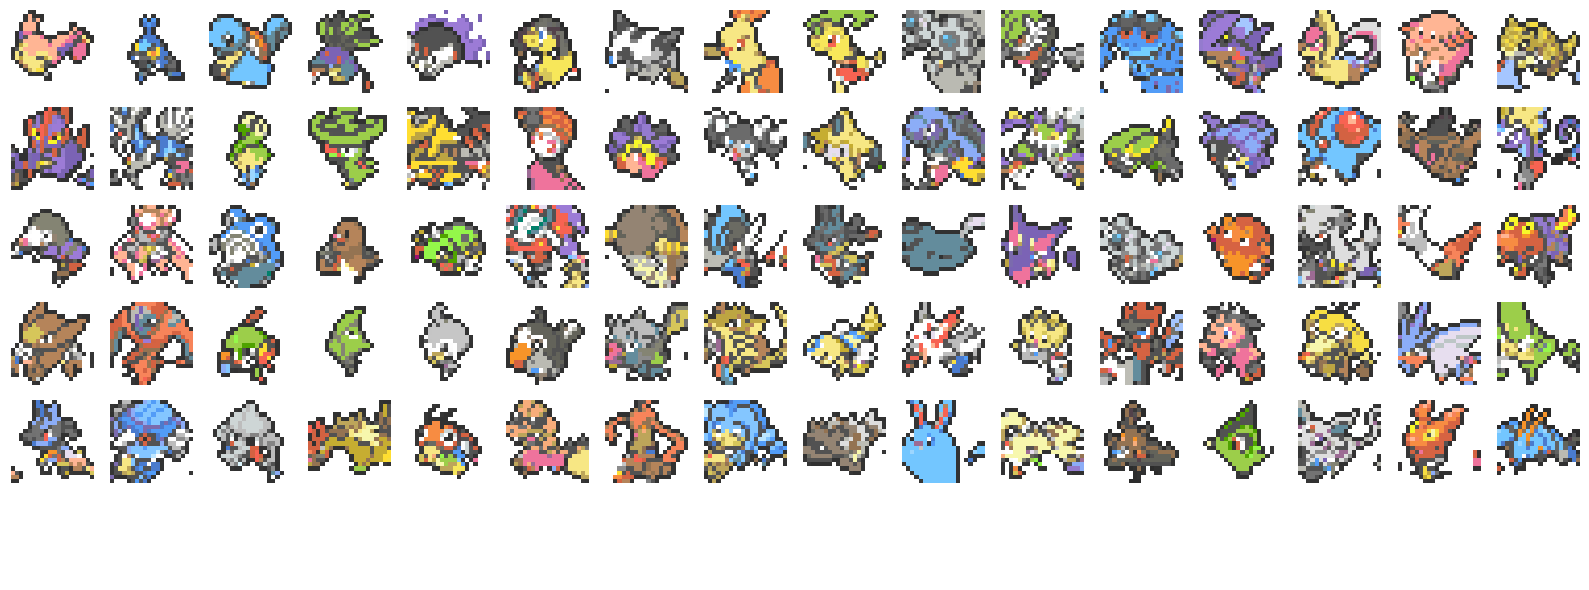

In [ ]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)